In [1]:
import numpy as np
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps

### Data

In [2]:
path= './data/chest_xray/'

train_NORMAL = os.path.join(path, 'train/NORMAL')
train_PNEUMONIA = os.path.join(path, 'train/PNEUMONIA')
test_NORMAL = os.path.join(path, 'test/NORMAL')
test_PNEUMONIA = os.path.join(path, 'test/PNEUMONIA')
val_NORMAL = os.path.join(path, 'val/NORMAL')
val_PNEUMONIA = os.path.join(path, 'val/PNEUMONIA')
train_NORMAL_DIR = [os.path.join(train_NORMAL, x) for x in os.listdir(train_NORMAL)]
train_PNEUMONIA_DIR = [os.path.join(train_PNEUMONIA, x) for x in os.listdir(train_PNEUMONIA)]
test_NORMAL_DIR = [os.path.join(test_NORMAL, x) for x in os.listdir(test_NORMAL)]
test_PNEUMONIA_DIR = [os.path.join(test_PNEUMONIA, x) for x in os.listdir(test_PNEUMONIA)]
val_NORMAL_DIR = [os.path.join(val_NORMAL, x) for x in os.listdir(val_NORMAL)]
val_PNEUMONIA_DIR = [os.path.join(val_PNEUMONIA, x) for x in os.listdir(val_PNEUMONIA)]
dataset = {
    "train_NORMAL":train_NORMAL_DIR,
    "train_PNEUMONIA":train_PNEUMONIA_DIR,
    "test_NORMAL":test_NORMAL_DIR,
    "test_PNEUMONIA":test_PNEUMONIA_DIR,
    "val_NORMAL":val_NORMAL_DIR,
    "val_PNEUMONIA":val_PNEUMONIA_DIR
    }

### Visual

In [3]:
#Normal pic 
rand_pic_normal = random.choice(train_NORMAL_DIR)
rand_pic_normal

'./data/chest_xray/train/NORMAL\\NORMAL2-IM-0946-0001.jpeg'

In [4]:
#Pneumonia
rand_pic_pneum = random.choice(train_PNEUMONIA_DIR)
rand_pic_pneum

'./data/chest_xray/train/PNEUMONIA\\person801_virus_1434.jpeg'

Text(0.5, 1.0, 'Pneumonia')

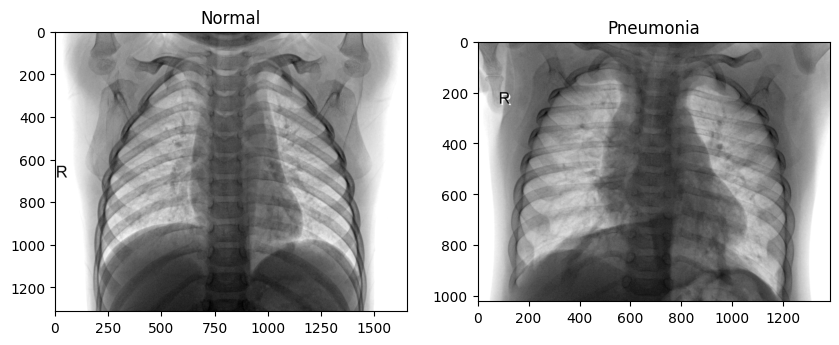

In [5]:
#Let's plot these images
f = plt.figure(figsize= (10,6))

a1 = f.add_subplot(1,2,1)
plt.imshow(ImageOps.invert(Image.open(rand_pic_normal).convert('L')), cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
plt.imshow(ImageOps.invert(Image.open(rand_pic_pneum).convert('L')), cmap='gray')
a2.set_title('Pneumonia')

In [6]:
def show_image(path: list, dataset:str, label:str, num_pics=2):
  # Routine to plot the images
  if num_pics > 1:
    fig, ax = plt.subplots(1, num_pics, sharex=True)
    plt.tight_layout()
    ax = ax.ravel()
    for idx, pth in enumerate(path[:num_pics]):
      ax[idx].imshow(plt.imread(pth), cmap='gray')
    fig.suptitle('Dataset: {}, Label: {}'.format(dataset, label))
  elif num_pics == 1:
    plt.imshow(plt.imread(path[:num_pics][0]), cmap='gray')
    plt.title('Dataset: {}, Label: {}'.format(dataset, label))
    plt.figure()

def visualize_dataset_distribution(dataset: dict, x_label: str, y_label: str, title: str):
  # Routine to visualize the per class distribution of the dataset
  folders = list(dataset.keys())
  folders_vals = list(map(lambda x: len(dataset[x]), folders))
  folders_paths = ['_'.join(x.split("/")[-2:]) for x in folders]
  for idx, f in enumerate(folders_paths):
    print('{}: contains {} images'.format(folders_paths[idx], folders_vals[idx]))
  plt.bar(folders_paths, folders_vals, width = 0.5, color = 'blue', align = 'center', edgecolor = 'black')
  plt.xticks(rotation=70)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title("Distribution of images in the dataset")
  plt.show()

def plot_confusion_matrix_self(cm, classes, title, cmap):
  plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  fmt = 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.ylabel(ylabel = 'True label', labelpad = 25)
  plt.xlabel(xlabel = 'Predicted label', labelpad = 25)
  plt.show()

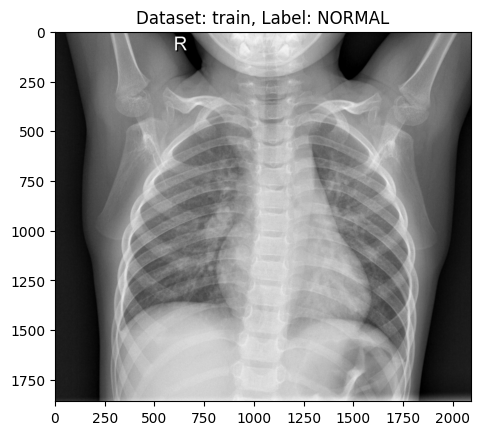

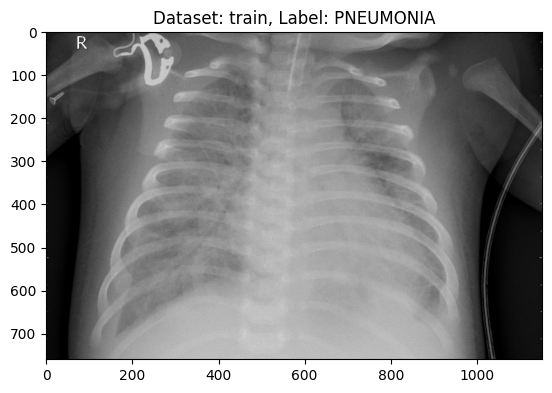

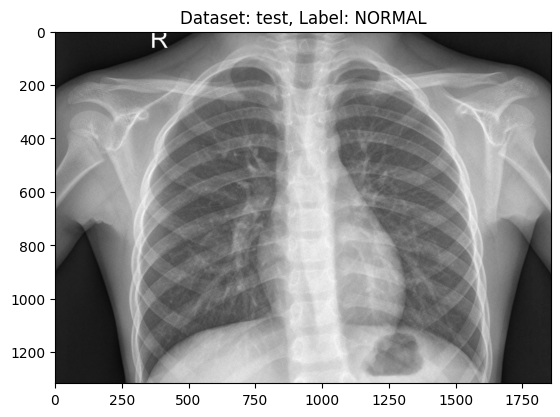

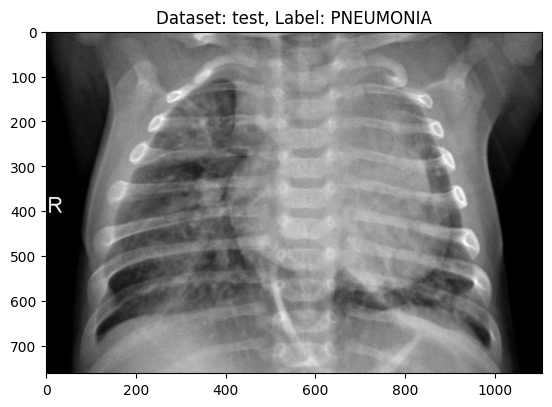

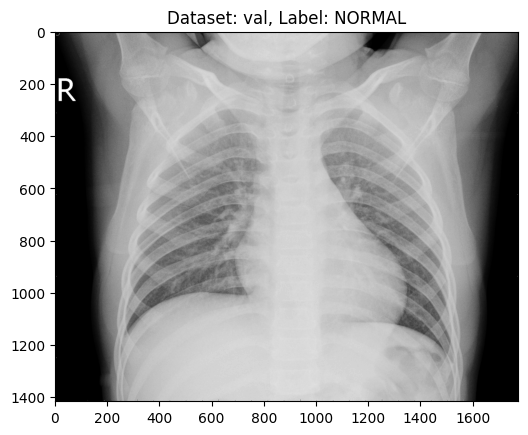

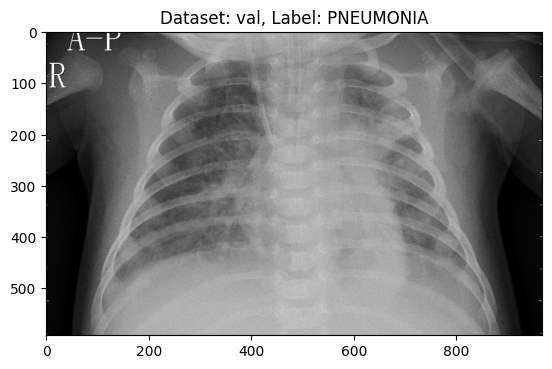

<Figure size 640x480 with 0 Axes>

In [7]:
# Visualizing the first num_pics image in the train, test and val datasets 
show_image(dataset["train_NORMAL"], num_pics=1, dataset="train", label="NORMAL")
show_image(dataset["train_PNEUMONIA"], num_pics=1, dataset="train", label="PNEUMONIA")

show_image(dataset["test_NORMAL"], num_pics=1, dataset="test", label="NORMAL")
show_image(dataset["test_PNEUMONIA"], num_pics=1, dataset="test", label="PNEUMONIA")

show_image(dataset["val_NORMAL"], num_pics=1, dataset="val", label="NORMAL")
show_image(dataset["val_PNEUMONIA"], num_pics=1, dataset="val", label="PNEUMONIA")

train_NORMAL: contains 1341 images
train_PNEUMONIA: contains 3875 images
test_NORMAL: contains 234 images
test_PNEUMONIA: contains 390 images
val_NORMAL: contains 8 images
val_PNEUMONIA: contains 8 images


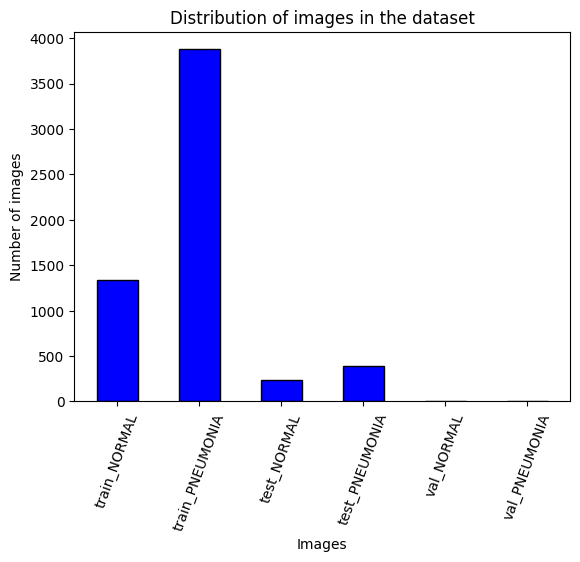

In [8]:
# Visualizing the datasets
x_label = "Images"
y_label = "Number of images"
title = "Distribution of images in the dataset"
visualize_dataset_distribution(dataset=dataset, x_label=x_label, y_label=y_label, title=title)

### Preprocess

In [9]:
# Function to preprocess and save images
def preprocess_and_save_images(source_dir, target_dir, target_size=(128, 128)):
    datagen = ImageDataGenerator(rescale=1./255)
    
    # Ensure the target directory exists
    os.makedirs(target_dir, exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'PNEUMONIA'), exist_ok=True)
    
    # Create a generator for the source directory
    generator = datagen.flow_from_directory(
        source_dir,
        target_size=target_size,
        batch_size=1,  # Process one image at a time
        class_mode=None,  # Only data, no labels
        shuffle=False  # Keep the same order
    )

    for i in range(len(generator)):
        # Get the image and file path from the generator
        image = generator[i][0] * 255  # Revert rescale to original scale
        image = image.astype(np.uint8)
        
        # Get the corresponding file path and label from the generator
        original_filepath = generator.filepaths[i]
        label = 'NORMAL' if generator.labels[i] == 0 else 'PNEUMONIA'
        filename = os.path.basename(original_filepath)
        
        # Construct the target file path
        target_filepath = os.path.join(target_dir, label, filename)
        
        # Check if the file already exists in the target directory
        if os.path.exists(target_filepath):
            continue
        
        # Convert to PIL Image and save
        img = Image.fromarray(image)
        img.save(target_filepath)
        
    print(f"Saved processed images to {target_dir}")

In [10]:
path_pr = './data/preporcessed'

preprocess_and_save_images(f'{path}train/', f'{path_pr}/train/')
preprocess_and_save_images(f'{path}val/', f'{path_pr}/val/')
preprocess_and_save_images(f'{path}test/', f'{path_pr}/test/')


Found 5216 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/train/
Found 16 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/val/
Found 624 images belonging to 2 classes.
Saved processed images to ./data/preporcessed/test/


###  Модель IVGG13

In [11]:
def create_ivgg13_model():
    model = Sequential([
        Input(shape=(128, 128, 3)),

        # Conv 1 : 128*128*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Conv 2 : 128*128*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Pool 1: 64*64*32
        MaxPooling2D((2, 2)),

        # Conv 3 : 64*64*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Conv 4 : 64*64*32
        Conv2D(32, (3, 3), activation='relu', padding='same'),

        # Pool 2 : 32*32*32
        MaxPooling2D((2, 2)),

        # Conv 5 : 32*32*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Conv 6 : 32*32*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Pool 3 : 16*16*64
        MaxPooling2D((2, 2)),

        # Conv 7 : 16*16*128
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Conv 8 : 16*16*128
        Conv2D(128, (3, 3), activation='relu', padding='same'),

        # Pool 4 : 8*8*128
        MaxPooling2D((2, 2)),

        # Conv 9 : 8*8*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Conv 10 : 8*8*64
        Conv2D(64, (3, 3), activation='relu', padding='same'),

        # Pool 5 : 4*4*64
        MaxPooling2D((2, 2)),

        # Flatten : 1024
        Flatten(),

        # FC14 Dense : 1024
        Dense(1024, activation='relu'),

        # FC15 Dense : 1024
        Dense(1024, activation='relu'),

        # FC16: 2 classes (sigmoid for binary classification)
        Dense(1, activation='sigmoid')
    ])

    return model

In [20]:
# Создаем модель
model = create_ivgg13_model()

# Компилируем модель
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Augmentation

In [13]:
# Создаем генератор для аугментации данных
datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=2,
    width_shift_range=0.005,
    height_shift_range=0.005,
    shear_range=0.005,
    zoom_range=0.005,
    vertical_flip=False,
    fill_mode='nearest',
    horizontal_flip = True
)

train_pr_dir = f'{path_pr}/train/'

# Определяем папку для NORMAL в тренировочном наборе
train_normal_dir = os.path.join(train_pr_dir, 'NORMAL')

normal_images = os.listdir(train_normal_dir)

# Применяем аугментацию и сохраняем изображения
for img_name in tqdm(normal_images, desc='Augmenting and saving images'):
    img_path = os.path.join(train_normal_dir, img_name)
    img = load_img(img_path)  # Загружаем изображение
    x = img_to_array(img)  # Преобразуем изображение в массив numpy
    x = x.reshape((1,) + x.shape)  # Решейпим для генератора
    i = 0
    for batch in datagen_aug.flow(x, batch_size=1, save_to_dir=train_normal_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 2:  # Применяем аугментацию к каждому изображению 2 раза
            break

Augmenting and saving images: 100%|██████████| 1341/1341 [00:10<00:00, 131.89it/s]


In [21]:
# Подсчитываем количество изображений в каждой папке
num_train_normal = len(os.listdir(train_normal_dir))
num_train_pneumonia = len(os.listdir(os.path.join(train_pr_dir, 'PNEUMONIA')))

# Выводим количество изображений в каждом классе
print(f"Train NORMAL: {num_train_normal} images")
print(f"Train PNEUMONIA: {num_train_pneumonia} images")

Train NORMAL: 3678 images
Train PNEUMONIA: 3875 images


### Генераторы данных

In [22]:
# Создаем генераторы данных
def create_generators(train_dir, val_dir, test_dir, target_size=(128, 128), batch_size=32):
        
    datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA']
    )

    validation_generator = datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA']
    )

    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        #classes=['NORMAL', 'PNEUMONIA'],
        #shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [23]:
# Получаем генераторы данных
train_generator, validation_generator, test_generator = create_generators(f'{path_pr}/train/', f'{path_pr}/val/', f'{path_pr}/test/')

Found 7553 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:
# Обеспечение повторения данных для валидационного генератора
def repeat_validation_generator(generator):
    while True:
        for data in generator:
            yield data

In [25]:
# Расчет steps_per_epoch и validation_steps
steps_per_epoch_train = train_generator.samples // train_generator.batch_size

print(f"steps_per_epoch_train: {steps_per_epoch_train}")

steps_per_epoch_train: 236


In [26]:
# Обучаем модель
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=repeat_validation_generator(validation_generator),
    validation_steps=steps_per_epoch_train
)

Epoch 1/5


C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


237/237 ━━━━━━━━━━━━━━━━━━━━ 90s 363ms/step - accuracy: 0.6503 - loss: 0.5650 - val_accuracy: 0.8125 - val_loss: 0.4966
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 366ms/step - accuracy: 0.9594 - loss: 0.1151 - val_accuracy: 0.8750 - val_loss: 0.2499
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 89s 375ms/step - accuracy: 0.9590 - loss: 0.1241 - val_accuracy: 0.8750 - val_loss: 0.2586
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 87s 367ms/step - accuracy: 0.9700 - loss: 0.0830 - val_accuracy: 0.8125 - val_loss: 0.5589
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 88s 371ms/step - accuracy: 0.9771 - loss: 0.0555 - val_accuracy: 0.9375 - val_loss: 0.1521


In [27]:
# Получаем предсказания модели для тестового набора данных
predictions = model.predict(test_generator)
predictions_binary = np.where(predictions > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes = test_generator.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
precision = precision_score(true_classes, predictions_binary)
recall = recall_score(true_classes, predictions_binary)
f1 = f1_score(true_classes, predictions_binary)

print(f'Accuracy: {test_acc}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'f1: {f1}\n')

# Строим confusion matrix
cm = confusion_matrix(true_classes, predictions_binary)
print("Confusion Matrix:")
print(cm, '\n')

# Нормализованная confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8245 - loss: 1.0531
Accuracy: 0.8273026347160339
Precision: 0.6270833333333333
Recall: 0.7717948717948718
f1: 0.6919540229885057

Confusion Matrix:
[[ 55 179]
 [ 89 301]] 

Normalized Confusion Matrix:
[[0.23504274 0.76495726]
 [0.22820513 0.77179487]]


Accuracy (Точность): Модель достигла accuracy примерно 82.7%, что означает, что она правильно классифицировала 82.7% всех образцов в тестовом наборе данных. Это довольно неплохой результат, но стоит учитывать, что для некоторых задач может потребоваться еще более высокая точность.

Precision (Точность): Precision для модели составила примерно 62.7%. Это показывает, что из всех образцов, которые модель предсказала как положительные (нормальные или пневмония), действительно положительными оказались 62.7%. Более высокая точность была бы желательна, особенно если важно минимизировать число ложноположительных результатов.

Recall (Полнота): Recall составил примерно 77.2%. Это означает, что модель корректно определила 77.2% всех действительно положительных образцов (нормальных и пневмония). Это важная метрика для задач, где необходимо уловить как можно больше положительных случаев.

F1 Score: F1 Score, который является гармоническим средним между precision и recall, составил около 69.2%. Этот показатель помогает сбалансировать точность и полноту в одну общую метрику. Чем выше F1 Score, тем лучше модель.

Confusion Matrix (Матрица ошибок): Анализ confusion matrix показывает, что модель делает больше ошибок при классификации нормальных изображений, которые ошибочно отмечены как пневмония (179 случаев). Также есть некоторое количество пневмоний, которые классифицированы как нормальные (89 случаев).

Normalized Confusion Matrix (Нормализованная матрица ошибок): Нормализованная матрица ошибок позволяет увидеть процентное соотношение правильно и неправильно классифицированных образцов по каждому классу. Она показывает, что около 23.5% нормальных изображений были ошибочно классифицированы как пневмония, а 22.8% пневмоний - как нормальные. Остальные образцы были правильно классифицированы в обоих случаях.

### Model 2

In [30]:
def create_ivgg13_model2():
    model = Sequential([
        Input(shape=(128, 128, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(1, activation='sigmoid')  # два класса: NORMAL и PNEUMONIA
    ])
    
    return model

In [38]:
# Получаем генераторы данных
train_generator2, validation_generator2, test_generator2 = create_generators(f'{path_pr}/train/', f'{path_pr}/val/', f'{path_pr}/test/', batch_size=32)

Found 7553 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [39]:
from tensorflow.keras.optimizers import Adam

# Задаем learning rate
learning_rate = 0.001

# Создаем оптимизатор с заданным learning rate
optimizer = Adam(learning_rate=learning_rate)

model2 = create_ivgg13_model2()
model2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [40]:
# Обучаем модель
train_generator2.reset()
validation_generator2.reset()

history2 = model2.fit(
    train_generator2,
    epochs=10,
    validation_data=repeat_validation_generator(validation_generator2),
    validation_steps=16
)

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 311ms/step - accuracy: 0.6564 - loss: 0.5356 - val_accuracy: 0.6875 - val_loss: 0.5890
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 315ms/step - accuracy: 0.9639 - loss: 0.1017 - val_accuracy: 0.8750 - val_loss: 0.1399
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 77s 324ms/step - accuracy: 0.9728 - loss: 0.0806 - val_accuracy: 1.0000 - val_loss: 0.0715
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 316ms/step - accuracy: 0.9820 - loss: 0.0536 - val_accuracy: 0.8750 - val_loss: 0.1519
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 76s 321ms/step - accuracy: 0.9825 - loss: 0.0510 - val_accuracy: 0.8750 - val_loss: 0.2143
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 75s 317ms/step - accuracy: 0.9841 - loss: 0.0441 - val_accuracy: 0.9375 - val_loss: 0.1509
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 76s 320ms/step - accuracy: 0.9833 - loss: 0.0429 - val_accuracy: 0.9375 - val_loss: 0.1746
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 106s 446ms/step - accuracy: 0.9899 - loss: 

In [59]:
# Получаем предсказания модели для тестового набора данных
predictions2 = model2.predict(test_generator2)
predictions_binary2 = np.where(predictions2 > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes2 = test_generator2.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss2, test_acc2 = model.evaluate(test_generator2, steps=test_generator2.samples // test_generator2.batch_size)
precision2 = precision_score(true_classes2, predictions_binary2)
recall2 = recall_score(true_classes2, predictions_binary2)
f12 = f1_score(true_classes2, predictions_binary2)

print(f'Accuracy: {test_acc2}')
print(f'Precision: {precision2}')
print(f'Recall: {recall2}')
print(f'f1: {f12}\n')

# Строим confusion matrix
cm2 = confusion_matrix(true_classes2, predictions_binary2)
print("Confusion Matrix:")
print(cm2, '\n')

# Нормализованная confusion matrix
cm_normalized2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized2)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.8275 - loss: 1.1579
Accuracy: 0.8256579041481018
Precision: 0.6181102362204725
Recall: 0.8051282051282052
f1: 0.6993318485523385

Confusion Matrix:
[[ 40 194]
 [ 76 314]] 

Normalized Confusion Matrix:
[[0.17094017 0.82905983]
 [0.19487179 0.80512821]]


Accuracy (точность) модели составляет примерно 82.6%, что означает, что модель правильно классифицировала около 82.6% всех изображений.
Precision (точность) для класса PNEUMONIA составляет примерно 61.8%. Это означает, что из всех предсказанных моделью случаев PNEUMONIA, только 61.8% действительно являются PNEUMONIA.
Recall (полнота) для класса PNEUMONIA составляет примерно 80.5%. Это говорит о том, что модель смогла обнаружить 80.5% всех действительных случаев PNEUMONIA.
F1-score (среднее гармоническое между precision и recall) равен 69.9%, что учитывает баланс между точностью и полнотой.
Матрица ошибок показывает, что модель совершила 40 верных предсказаний для класса NORMAL и 314 верных предсказаний для класса PNEUMONIA. Однако она также допустила 194 ошибочных предсказаний для класса NORMAL и 76 ошибочных предсказаний для класса PNEUMONIA.

Нормализованная матрица ошибок демонстрирует долю правильных и ошибочных классификаций в процентном соотношении для каждого класса.

Эти результаты показывают, что модель демонстрирует улучшение в показателях полноты (recall), но есть потенциал для улучшения в точности (precision) и общей точности (accuracy).

### Model 3

In [52]:
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Conv2D(32, (3, 3), activation="relu"))
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))

cnn_model.add(Flatten())

cnn_model.add(Dense(activation = 'relu', units = 128))
cnn_model.add(Dense(activation = 'sigmoid', units = 1))

In [53]:
cnn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [55]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_set = train_datagen.flow_from_directory(f'{path_pr}/train/',
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale = 1./255)

validation_generator = test_datagen.flow_from_directory(f'{path_pr}/val/',
                                                        target_size=(128, 128),
                                                        batch_size=32,
                                                        class_mode='binary')

test_set = test_datagen.flow_from_directory(f'{path_pr}/test/',
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 7553 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [57]:
cnn_model_his = cnn_model.fit(train_set,
                              steps_per_epoch = 163,
                              epochs = 10,
                              validation_data = validation_generator,
                              validation_steps = 624)

Epoch 1/10


C:\Users\grayni\Desktop\tr_py\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.7168 - loss: 0.5445 - val_accuracy: 0.8750 - val_loss: 0.2708
Epoch 2/10
  1/163 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.9062 - loss: 0.2117

C:\Python3121\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9035 - loss: 0.2569 - val_accuracy: 0.8125 - val_loss: 0.3488
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.9024 - loss: 0.2522 - val_accuracy: 0.7500 - val_loss: 0.5189
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step - accuracy: 0.9178 - loss: 0.1939 - val_accuracy: 0.8125 - val_loss: 0.5645
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 169ms/step - accuracy: 0.9297 - loss: 0.1813 - val_accuracy: 0.7500 - val_loss: 0.4947
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9271 - loss: 0.1905 - val_accuracy: 0.6875 - val_loss: 0.8123
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.9190 - loss: 0.1967 - val_accuracy: 0.8750 - val_loss: 0.3610
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9280 - loss: 0.1739 - val_accuracy: 0.7500 - val_loss: 0.6321
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 28s 166ms/step - accuracy: 0.9380 - loss: 0.1604 - val_acc

In [63]:
# Получаем предсказания модели для тестового набора данных
predictions3 = cnn_model.predict(test_set)
predictions_binary3 = np.where(predictions3 > 0.5, 1, 0)

# Истинные метки классов для тестового набора данных
true_classes3 = test_set.classes

# Вычисляем accuracy, precision, recall, F1 Score
test_loss3, test_acc3 = cnn_model.evaluate(test_set, steps=test_set.samples // test_set.batch_size)
precision3 = precision_score(true_classes3, predictions_binary3)
recall3 = recall_score(true_classes3, predictions_binary3)
f13 = f1_score(true_classes3, predictions_binary3)

print(f'Accuracy: {test_acc3}')
print(f'Precision: {precision3}')
print(f'Recall: {recall3}')
print(f'f1: {f13}\n')

# Строим confusion matrix
cm3 = confusion_matrix(true_classes3, predictions_binary3)
print("Confusion Matrix:")
print(cm3, '\n')

# Нормализованная confusion matrix
cm_normalized3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]
print("Normalized Confusion Matrix:")
print(cm_normalized3)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8369 - loss: 0.5369
Accuracy: 0.8355262875556946
Precision: 0.6265822784810127
Recall: 0.7615384615384615
f1: 0.6875

Confusion Matrix:
[[ 57 177]
 [ 93 297]] 

Normalized Confusion Matrix:
[[0.24358974 0.75641026]
 [0.23846154 0.76153846]]


Модель достигла accuracy (точности) около 83.6%, что означает, что она правильно классифицировала около 83.6% всех изображений в тестовом наборе данных.

Precision (точность) для класса PNEUMONIA составляет примерно 62.7%. Это говорит о том, что из всех предсказанных моделью случаев PNEUMONIA, только 62.7% действительно являются PNEUMONIA.

Recall (полнота) для класса PNEUMONIA составляет примерно 76.2%. Это показывает, что модель смогла обнаружить 76.2% всех действительных случаев PNEUMONIA.

F1-score (среднее гармоническое между precision и recall) равен 68.8%, что указывает на хороший баланс между точностью и полнотой.

Матрица ошибок демонстрирует, что модель правильно классифицировала 57 изображений как NORMAL и 297 изображений как PNEUMONIA. Однако она также ошибочно классифицировала 177 изображений как NORMAL и 93 изображения как PNEUMONIA.

### ROC

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_model1, tpr_model1, thresholds_model1 = roc_curve(test_generator.classes, predictions)
auc_model1 = roc_auc_score(test_generator.classes, predictions)

fpr_model2, tpr_model2, thresholds_model2 = roc_curve(test_generator2.classes, predictions2)
auc_model2 = roc_auc_score(test_generator2.classes, predictions2)

fpr_model3, tpr_model3, thresholds_model3 = roc_curve(test_set.classes, predictions3)
auc_model3 = roc_auc_score(test_set.classes, predictions3)

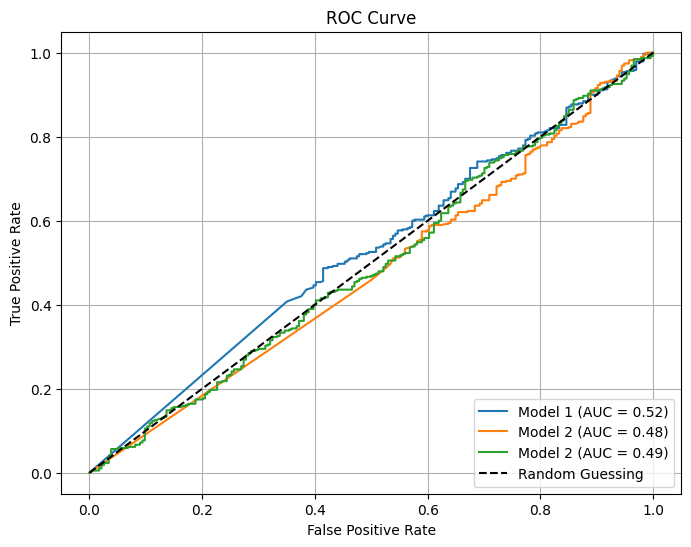

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_model1, tpr_model1, label=f'Model 1 (AUC = {auc_model1:.2f})')
plt.plot(fpr_model2, tpr_model2, label=f'Model 2 (AUC = {auc_model2:.2f})')
plt.plot(fpr_model3, tpr_model3, label=f'Model 2 (AUC = {auc_model3:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [66]:
# Находим оптимальный порог для модели 1 (примерно равное значение FPR и TPR)
optimal_idx_model1 = np.argmax(tpr_model1 - fpr_model1)
optimal_threshold_model1 = thresholds_model1[optimal_idx_model1]

# Находим оптимальный порог для модели 2 (примерно равное значение FPR и TPR)
optimal_idx_model2 = np.argmax(tpr_model2 - fpr_model2)
optimal_threshold_model2 = thresholds_model2[optimal_idx_model2]

# Находим оптимальный порог для модели 3 (примерно равное значение FPR и TPR)
optimal_idx_model3 = np.argmax(tpr_model3 - fpr_model3)
optimal_threshold_model3 = thresholds_model3[optimal_idx_model3]

print(f'Optimal threshold for Model 1: {optimal_threshold_model1:.2f}')
print(f'Optimal threshold for Model 2: {optimal_threshold_model2:.2f}')
print(f'Optimal threshold for Model 3: {optimal_threshold_model3:.2f}')

Optimal threshold for Model 1: 1.00
Optimal threshold for Model 2: 0.00
Optimal threshold for Model 3: 0.59


Model 1 (threshold = 1.00):

Это означает, что модель принимает решение о классификации только в случае, если уверенность (вероятность) превышает 1.00. Вероятность предсказания для каждого класса обычно варьируется от 0 до 1. Значение порога 1.00 указывает на то, что модель принимает решение только при максимальной уверенности, что может привести к более консервативной классификации.
Model 2 (threshold = 0.00):

Это может интерпретироваться как то, что модель принимает решение о классификации при любой уверенности. Такой порог может означать, что модель склонна к более агрессивной классификации, даже при относительно низкой уверенности.
Model 3 (threshold = 0.59):

Здесь модель принимает решение о классификации при уверенности выше 0.59. Это значит, что модель будет более осторожной в классификации и будет требовать относительно высокой уверенности для принятия решения.